# Create Yolo annotation DB

In [1]:
import pandas as pd
import os
import cv2
import shutil


In [4]:
def create_dir(path):
    dirs = path.split("/")
    # print(dirs)
    n_path = ""
    for i in range(len(dirs)):
        
        n_path = os.path.join(n_path, dirs[i])
        # print(n_path)
        a = os.path.isdir(n_path)   
        # print(a) 
        if(not(a)):
            os.mkdir(n_path) 

In [5]:

#### Files and paths ####
selected_annotations_file = "../Data/Objects_Database/Selected_Objects_Information.csv"
db_dir = "../Datasets/Tobacco 800 Dataset/tobacco800/"


selected_annotations_df = pd.read_csv(selected_annotations_file)
selected_annotations_df.head()

,image_name,docid,label,x,y,w,h,logo_label
0,bjn43c00-page02_1,bjn43c00-page02_1_obj2.png,logo,724,209,209,216,4
1,gpq38e00-page02_2,gpq38e00-page02_2_obj0.png,logo,852,101,973,406,2
2,hna35f00,hna35f00_obj2.png,logo,141,24,335,130,1
3,gcv85f00,gcv85f00_obj0.png,logo,68,35,229,201,8
4,ifw98c00,ifw98c00_obj0.png,logo,116,307,1467,197,3


In [6]:
label_map = {
    "logo": 0,
    "signature": 1,
    "other": 2
}
selected_annotations_df["label"] = selected_annotations_df["label"].map(label_map)
selected_annotations_df.head()

,image_name,docid,label,x,y,w,h,logo_label
0,bjn43c00-page02_1,bjn43c00-page02_1_obj2.png,0,724,209,209,216,4
1,gpq38e00-page02_2,gpq38e00-page02_2_obj0.png,0,852,101,973,406,2
2,hna35f00,hna35f00_obj2.png,0,141,24,335,130,1
3,gcv85f00,gcv85f00_obj0.png,0,68,35,229,201,8
4,ifw98c00,ifw98c00_obj0.png,0,116,307,1467,197,3


In [7]:
selected_annotations_df["label"].value_counts()

label
0    213
2    213
1    213
Name: count, dtype: int64

In [10]:
yolo_txt_dir = "../YOLOv8_PyTorch_TXT_DB/"
create_dir(yolo_txt_dir)

u_docs = selected_annotations_df["image_name"].unique()


for d in range(len(u_docs)):

    doc = u_docs[d]
    annotation_df = selected_annotations_df.loc[selected_annotations_df["image_name"]==doc, :]


    annotation_list = []

    for i in annotation_df.index:
        
        ## Obtain annotation information ##
        image_name = annotation_df.loc[i, "image_name"]
        x, y, w, h = annotation_df.loc[i, ["x", "y", "w", "h"]]
        label = annotation_df.loc[i, "label"]

        ## Obtain image dimentions ##
        src_file = os.path.join(db_dir, image_name+".png")
        img = cv2.imread(src_file)
        height, weight = img.shape[:2]
        
        ## Organize needed data ##
        c_x = x+w/2
        c_y = y+h/2

        ## Normalize coordinates ##
        n_c_x = c_x/weight
        n_w = w/weight

        n_c_y = c_y/height
        n_h = h/height

        ## Create annotation line ##
        line = f"{label} {n_c_x} {n_c_y} {n_w} {n_h}\n"
        ## store annotation line ##
        annotation_list.append(line)

        # print(image_name, label, height, weight, x, y, w, h)
        # print(image_name, label, height, weight, c_x, c_y, w, h)
        

    #### Save information at DB ####

    ## Copy image ##
    dst_file = os.path.join(yolo_txt_dir, image_name+".png")
    shutil.copy2(src_file, dst_file)

    ## save TXT file ##
    ann_file = os.path.join(yolo_txt_dir, image_name+".txt")
    file = open(ann_file, 'w')
    file.writelines(annotation_list)
    file.close()
 

# Merge annotation documents

## Libraries

In [2]:
import os
import pandas as pd
from tqdm import tqdm

## Load all files

In [25]:
## Path of annotated data ##
path = "../Data/Annotated_Images/"

## List folder with annotated data ##
folders_list = os.listdir(path)
print("# of folders:",len(folders_list))


## Counter of read csv files ##
c_csv = 0

## DF to save all annotations ##
annotated_df = pd.DataFrame([])

## Loop ##
for folder in tqdm(folders_list):
    
    ## create name of annotated information ##
    annotation_name = f"annotations_{folder}.csv"
    
    ## path of each folder ##
    annotation_file = os.path.join(path, folder, annotation_name)   
    
    ## Load annotations ##
    annotation_df = pd.read_csv(annotation_file)
    ## concatenate annotations ##
    annotated_df = pd.concat([annotated_df, annotation_df], axis=0)
    ## Increase loaded files ##
    c_csv += 1
            

annotated_df.reset_index(drop=True, inplace=True)

print("# of read files:", c_csv, annotated_df.shape)
annotated_df.head()


# of folders: 500


100%|██████████| 500/500 [00:00<00:00, 2018.18it/s]

# of read files: 500 (2137, 7)


,image_name,docid,label,x,y,w,h
0,gpq38e00-page02_2,gpq38e00-page02_2_obj0.png,l,852,101,973,406
1,gpq38e00-page02_2,gpq38e00-page02_2_obj1.png,f,805,2170,442,320
2,dlk65e00,dlk65e00_obj0.png,l,880,135,816,384
3,dlk65e00,dlk65e00_obj1.png,t,330,1345,1705,176
4,dlk65e00,dlk65e00_obj2.png,t,470,1239,148,81


## Check the assigned labels

In [26]:
annotated_df["label"].value_counts()

label
t            1234
f             529
l             232
b             114
g              21
e               3
logo            1
signature       1
tt              1
ff              1
Name: count, dtype: int64

## Re-define the labels

In [27]:

object_database_file = "../Data/Objects_Database/Objects_Information.csv"



map_dict = {
    "other": ["t", "o", "tt"],
    "signature": ["f", "ff", "s", "signature"],
    "logo": ["l", "logo"],
    "table": ["b"],
    "graphic": ["g"],
    "empty": ["e"],
}


label_list = []
for i in range(len(annotated_df)):
    label = annotated_df.loc[i, "label"]
    
    for key in map_dict.keys():

        if(label in map_dict[key]):
            label_list.append(key)

print(len(annotated_df))
print(len(label_list))


annotated_df_2 = annotated_df.copy()

annotated_df_2["label"] = label_list

annotated_df_2.to_csv(object_database_file, index=False)
annotated_df_2["label"].value_counts()

2137
2137


label
other        1235
signature     531
logo          233
table         114
graphic        21
empty           3
Name: count, dtype: int64

# Split images to database folder

## Libraries

In [8]:
import os
import shutil
import pandas as pd

## Functions

In [4]:
def create_dir(path):
    dirs = path.split("/")
    # print(dirs)
    n_path = ""
    for i in range(len(dirs)):
        
        n_path = os.path.join(n_path, dirs[i])
        # print(n_path)
        a = os.path.isdir(n_path)   
        # print(a) 
        if(not(a)):
            os.mkdir(n_path) 

## Copy images

In [14]:
object_database_file = "../Data/Objects_Database/Objects_Information.csv"
objects_info_df = pd.read_csv(object_database_file)


src_path = "../Data/Annotated_Images/"
db_path = "../Data/Objects_Database"

object_interest = ["logo", "other", "signature"]

for object in object_interest:

    dst_path = os.path.join(db_path, object)

    create_dir(dst_path)

    objects_df = objects_info_df.loc[objects_info_df["label"]==object, :]
    samples_df = objects_df.sample(n=233, random_state=21, ignore_index=True)
    

    for i in range(samples_df.shape[0]):
        
        src_file = os.path.join(src_path, samples_df.loc[i, "image_name"], samples_df.loc[i, "docid"])
        dst_file = os.path.join(dst_path, samples_df.loc[i, "docid"]) 

        shutil.copy2(src_file, dst_file)



## Redefine file of selected objects

## Libraries

In [1]:
import os
import pandas as pd

## Redefine file

In [3]:
object_database_file = "../Data/Objects_Database/Objects_Information.csv"
selected_object_db_file = "../Data/Objects_Database/Selected_Objects_Information.csv"

objects_info_df = pd.read_csv(object_database_file)
objects_info_df.index = list(objects_info_df["docid"])

db_path = "../Data/Objects_Database"

object_interest = ["logo", "other", "signature"]

object_list = []

for object in object_interest:
    dst_path = os.path.join(db_path, object)

    obj_list = os.listdir(dst_path)
    object_list.extend(obj_list)



selected_objects_df = objects_info_df.loc[object_list, :]
print(selected_objects_df.shape)


selected_objects_df.to_csv(selected_object_db_file, index=False)

(639, 7)


# Check labeling


In [1]:
import pandas as pd
import os
import shutil

In [2]:
def create_dir(path):
    dirs = path.split("/")
    # print(dirs)
    n_path = ""
    for i in range(len(dirs)):
        
        n_path = os.path.join(n_path, dirs[i])
        # print(n_path)
        a = os.path.isdir(n_path)   
        # print(a) 
        if(not(a)):
            os.mkdir(n_path) 

In [3]:
objects_file = "../Data/Objects_Database/Selected_Objects_Information.csv"

object_df = pd.read_csv(objects_file)

object_df = object_df.loc[object_df["label"]=="logo", :]

object_df["logo_label"].value_counts()


logo_label
1     39
2     35
3     27
4     25
5     19
6     13
7      8
8      6
9      6
10     5
11     3
12     3
13     3
17     2
15     2
16     2
29     2
14     2
24     1
27     1
23     1
25     1
26     1
19     1
22     1
21     1
20     1
28     1
18     1
Name: count, dtype: int64

In [4]:
src_path = "../Data/Objects_Database/logo/"
db_path = "../Data/Objects_Database/unique_logos/"

object_interest = list(object_df["logo_label"].unique())


for object in object_interest:

    dst_path = os.path.join(db_path, str(object))
    create_dir(dst_path)

    samples_df = object_df.loc[object_df["logo_label"]==object, :]
    
    for i in samples_df.index:
        
        src_file = os.path.join(src_path, samples_df.loc[i, "docid"])
        dst_file = os.path.join(dst_path, samples_df.loc[i, "docid"]) 

        shutil.copy2(src_file, dst_file)

# Graph different logos

In [2]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from math import ceil



In [3]:
def print_image(img, title, n_labels):
    # plt.figure()
    plt.imshow(img)
    plt.title(f"Img - {title}: {n_labels}")
    plt.xticks([])
    plt.yticks([])
    # plt.show()

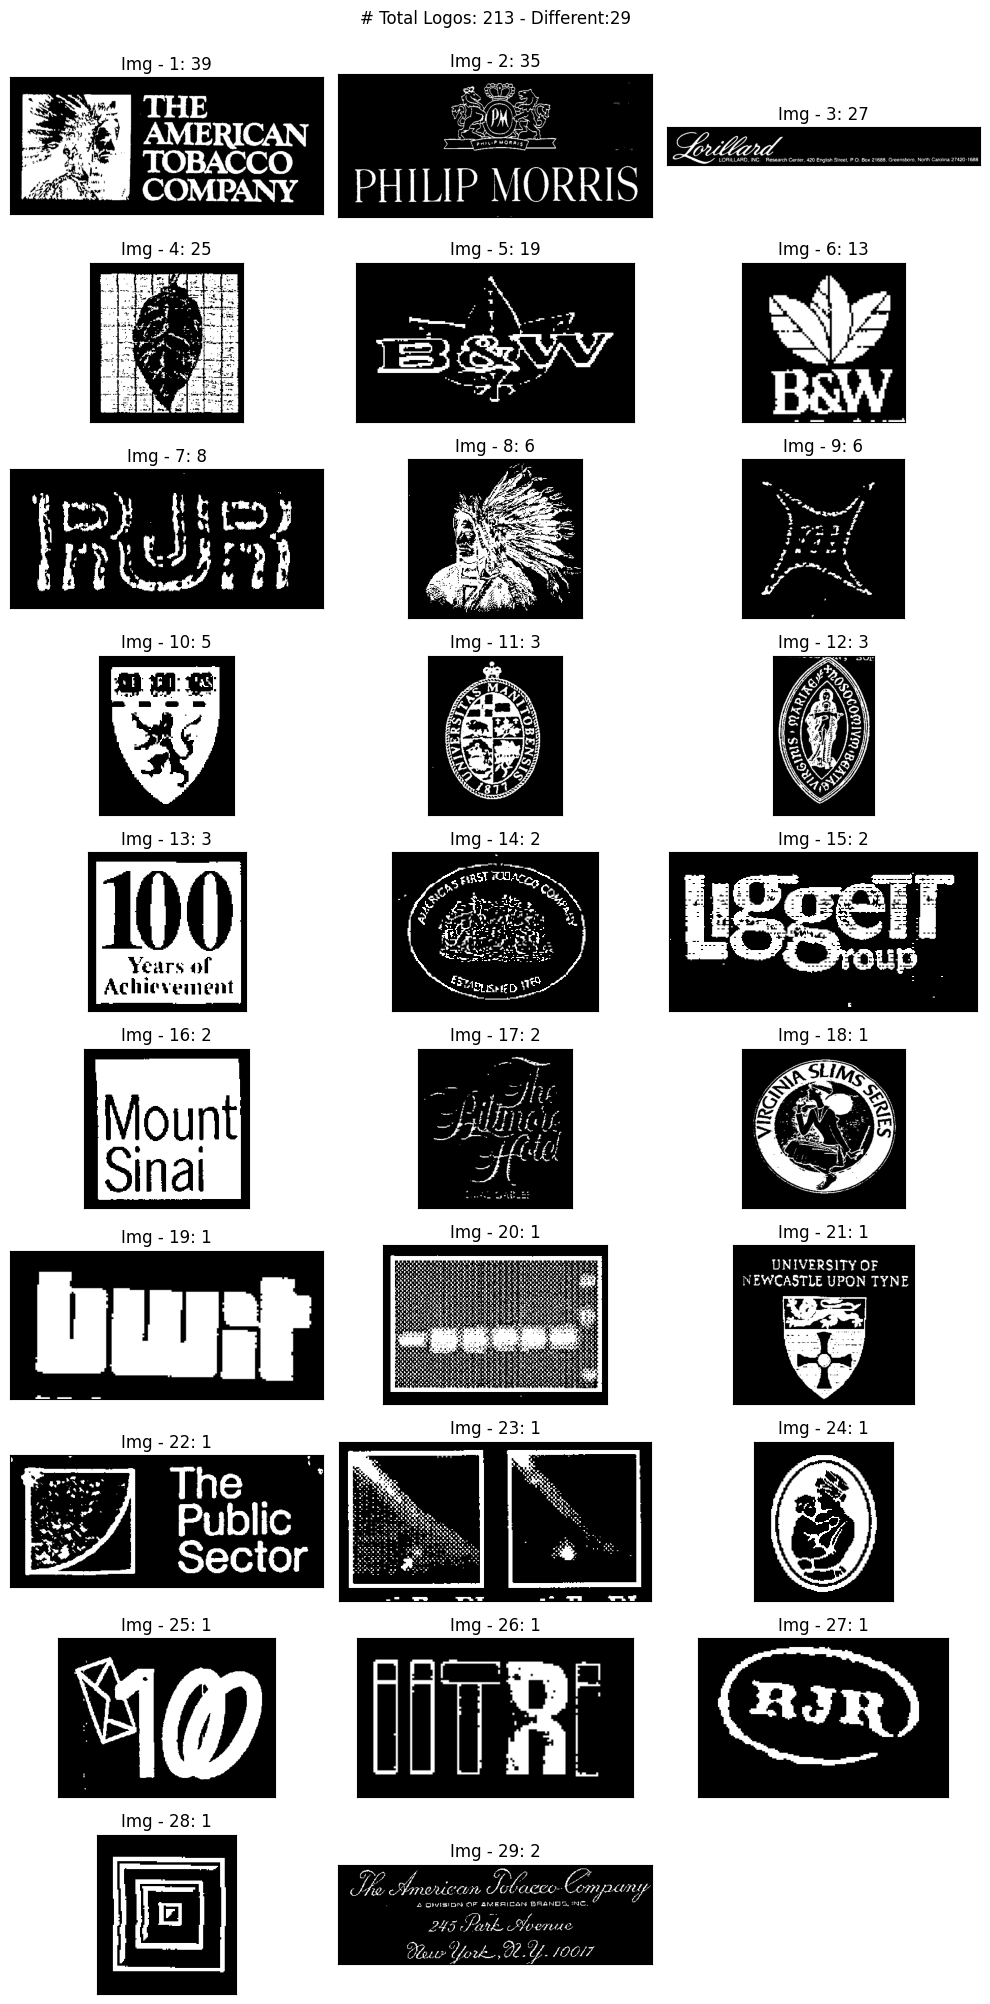

In [18]:
#### Fig name ####
fig_name = "../Data/Objects_Database/Information/Unique_Logos.pdf"

anotations_file = "../Data/Objects_Database/Selected_Objects_Information.csv"
annotated_df = pd.read_csv(anotations_file)

objects_path = "../Data/Objects_Database/logo/"

object_df = annotated_df.loc[annotated_df["label"]=="logo", :]

n_labels = object_df["logo_label"].nunique()

object_counts = object_df["logo_label"].value_counts()
object_counts.sort_index(inplace=True)

cols=3
rows = int(ceil(n_labels/cols))

fig = plt.figure(figsize=(10, 2*rows))

for i in range(n_labels):

    lab = object_counts.index[i]
    n_logos = object_counts[lab]
    
    image_name = object_df.loc[object_df["logo_label"]==lab, "docid"].values[-1]
    # print(lab,type(image_name), len(image_name))
    
    object_file = os.path.join(objects_path, image_name)

    img = cv2.imread(object_file)
    
    plt.subplot(rows, cols, i+1)
    print_image(img, lab, n_logos)
    
    
    # break
    
fig.suptitle(f"# Total Logos: {object_df.shape[0]} - Different:{n_labels}", y=1)
plt.tight_layout()
plt.savefig(fig_name)
plt.show()